<a href="https://colab.research.google.com/github/Supporter09/OptimizationHUST21/blob/main/Optimization_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plotRoutes(N, K, routes, algo_name = ""):
  color_palette = [
      'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple',
      'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
      '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
  ]
  # Randomly assign coordinates to N nodes + depot (node 0)
  np.random.seed(43)
  coordinates = np.random.rand(N + 1, 2) * 100  # Scale coordinates to [0, 100]

  # Example routes for cars
  # routes = [
  #     [0, 5, 1, 6, 0],  # Route for car 1
  #     [0, 2, 4, 3, 0],  # Route for car 2
  #     [0, 3, 4, 0],     # Route for car 3
  #     [0, 6, 2, 0]      # Route for car 4
  # ]

  # Plot the points (nodes)
  plt.figure(figsize=(10, 8))
  for i, (x, y) in enumerate(coordinates):
      plt.scatter(x, y, s=200, c='black' if i == 0 else 'tab:blue', label='Depot (0)' if i == 0 else "")
      plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white')

  # Plot the routes with arrows
  unique_colors = itertools.cycle(color_palette)  # Infinite iterator for colors
  route_colors = []  # Store colors to match legend

  for i, route in enumerate(routes):
      route_color = next(unique_colors)
      route_colors.append(route_color)

      for j in range(len(route) - 1):
          start, end = route[j], route[j+1]
          x_start, y_start = coordinates[start]
          x_end, y_end = coordinates[end]

          # Plot a line for the route
          plt.plot([x_start, x_end], [y_start, y_end], color=route_color, linewidth=2)

          # Add an arrow to indicate direction
          plt.annotate("",
                      xy=(x_end, y_end), xycoords='data',
                      xytext=(x_start, y_start), textcoords='data',
                      arrowprops=dict(arrowstyle="->", color=route_color, lw=2),
                      size=10)

  # Add legend
  legend_labels = [f"Car {i+1}" for i in range(len(routes))]
  for i, label in enumerate(legend_labels):
      plt.scatter([], [], color=route_colors[i], label=label)  # Empty scatter for legend entry

  plt.title(f"Vehicle Routing Problem Visualization {algo_name}")
  plt.xlabel("X Coordinate")
  plt.ylabel("Y Coordinate")
  plt.legend()
  plt.grid()
  plt.show()


In [62]:
import random
from typing import List

INF = int(1e9 + 7)

class Truck:
    def __init__(self):
        self.route = [0]
        self.distance = 0

def calc_distance(route: List[int], distance_matrix: List[List[int]]) -> int:
    """Calculates the total distance for a given route."""
    _distance = 0
    for i in range(1, len(route)):
        _distance += distance_matrix[route[i - 1]][route[i]]
    return _distance

def processRoutes(mixedTrucks):
    routes = []
    for truck in mixedTrucks:
        routes.append(truck.route)
    return routes

def solve_greedy(N: int, K: int, distance_matrix: List[List[int]]):
    """Solves the VRP problem using a greedy approach."""
    visited = [False] * (N + 1)
    visited[0] = True
    trucks = [Truck() for _ in range(K)]

    for i in range(1, N + 1):
        best_pos = -1
        best_distance = INF
        best_node = -1

        for node in range(1, N + 1):
            if visited[node]:
                continue

            for pos in range(K):
                _distance = trucks[pos].distance + distance_matrix[trucks[pos].route[-1]][node]
                if _distance < best_distance:
                    best_pos = pos
                    best_distance = _distance
                    best_node = node

        trucks[best_pos].route.append(best_node)
        trucks[best_pos].distance = best_distance
        visited[best_node] = True

    plotRoutes(N, K, processRoutes(trucks), "Greedy")
    return trucks

In [63]:
!pip install ortools


In [64]:
# LP Solution - For learning theorem only - Not suitable for running
from ortools.linear_solver import pywraplp

def solve_lp():
    # Đọc giá trị N và K
    N, K = map(int, input().split())

    # Đọc ma trận khoảng cách
    distance_matrix = []
    for _ in range(N + 1):
        distance_matrix.append(list(map(int, input().split())))

    # Chuyển khoảng cách từ vị trí bất kì trở lại điểm ban đầu (0) thành 0:
    for i in range(len(distance_matrix)):
        distance_matrix[i][0] = 0

    # Khởi tạo solver
    solver = pywraplp.Solver.CreateSolver('CBC')

    # Biến quyết định x[i][j][k]
    x = {}
    for i in range(N + 1):
        for j in range(N + 1):
            if i != j:
                for k in range(K):
                    x[i, j, k] = solver.BoolVar(f'x[{i},{j},{k}]')

    # Biến mục tiêu z: quãng đường dài nhất
    z = solver.NumVar(0, solver.infinity(), 'z')

    # Biến phụ u[i, k] để loại bỏ subtour
    u = {}
    for i in range(1, N + 1):
        for k in range(K):
            u[i, k] = solver.NumVar(0, N, f'u[{i},{k}]')

    # Hàm mục tiêu: Tối thiểu hóa z
    solver.Minimize(z)

    # Ràng buộc 1: Mỗi điểm chỉ được ghé qua một lần
    for i in range(1, N + 1):
        solver.Add(solver.Sum(x[i, j, k] for j in range(N + 1) for k in range(K) if i != j) == 1)

    # Ràng buộc 2: Mỗi xe bắt đầu từ kho
    for k in range(K):
        solver.Add(solver.Sum(x[0, j, k] for j in range(1, N + 1)) == 1)

    # Ràng buộc 3: Liên tục chuyến đi (xe phải rời khỏi điểm nếu đi vào)
    for k in range(K):
        for i in range(1, N + 1):
            solver.Add(solver.Sum(x[i, j, k] for j in range(N + 1) if i != j) ==
                      solver.Sum(x[j, i, k] for j in range(N + 1) if i != j))

    # Ràng buộc 4: Tổng quãng đường của mỗi xe phải <= z
    for k in range(K):
        solver.Add(solver.Sum(distance_matrix[i][j] * x[i, j, k]
                              for i in range(N + 1) for j in range(N + 1) if i != j) <= z)

    # Ràng buộc 5: Loại bỏ chu trình con (Subtour Elimination)
    for k in range(K):
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                if i != j:
                    solver.Add(u[i, k] - u[j, k] + (N * x[i, j, k]) <= N - 1)

    # Hàm tính tổng cost
    def calculate_cost():
        total_cost = 0
        for k in range(K):
            current_location = 0  # Bắt đầu từ kho
            while True:
                next_location = None
                for j in range(N + 1):
                    if current_location != j and x[current_location, j, k].solution_value() > 0.5:
                        total_cost += distance_matrix[current_location][j]  # Cộng chi phí vào tổng
                        next_location = j
                        break
                if next_location is None or next_location == 0:
                    break
                current_location = next_location
        return total_cost

    # Giải bài toán
    status = solver.Solve()

    # In kết quả
    if status == pywraplp.Solver.OPTIMAL:
        # Tính tổng chi phí (cost)
        total_cost = calculate_cost()
        print(f'Total cost: {total_cost}')  # In tổng chi phí

        #    # Uncomment the follow code to print out route
        # print(K)  # Line 1: Số lượng xe
        # for k in range(K):
        #     route = []
        #     current_location = 0  # Bắt đầu từ kho
        #     while True:
        #         next_location = None
        #         for j in range(N + 1):
        #             if current_location != j and x[current_location, j, k].solution_value() > 0.5:
        #                 route.append(j)
        #                 next_location = j
        #                 break
        #         if next_location is None or next_location == 0:
        #             break
        #         current_location = next_location
        #     print(len(route))  # Line 2 * k: Số điểm xe đi qua
        #     print('0 ' + ' '.join(map(str, route[:-1])))  # Line 2 * k + 1: Các điểm mà xe đi qua
    else:
        print('The problem does not have an optimal solution.')

In [65]:
"""Simple Vehicles Routing Problem (VRP).

   This is a sample using the routing library python wrapper to solve a VRP
   problem.
   A description of the problem can be found here:
   http://en.wikipedia.org/wiki/Vehicle_routing_problem.

   Distances are in meters.
   CP solution
"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


# def create_data_model():
#     """Stores the data for the problem."""
#     data = {}
#     data["distance_matrix"] = [
#         # fmt: off
#       [0, 9, 9, 9, 7, 2, 9],
#         [9, 0, 3, 0, 2, 8, 1],
#         [9, 3, 0, 3, 4, 7, 4],
#         [9, 0, 3, 0, 2, 8, 1],
#         [7, 2, 4, 2, 0, 6, 2],
#         [2, 8, 7, 8, 6, 0, 8],
#         [9, 1, 4, 1, 2, 8, 0]
#         # fmt: on
#     ]
#     data["num_vehicles"] = 2
#     data["depot"] = 0
#     data["num_package"] = 6
#     return data

def read_input():
    # Đọc giá trị N và K
    N, K = map(int, input().split())

    # Đọc ma trận khoảng cách
    distance_matrix = []
    for _ in range(N + 1):
        distance_matrix.append(list(map(int, input().split())))
    '''N = 6
    K = 2
    distance_matrix = [
        [0, 9, 9, 9, 7, 2, 9],
        [9, 0, 3, 0, 2, 8, 1],
        [9, 3, 0, 3, 4, 7, 4],
        [9, 0, 3, 0, 2, 8, 1],
        [7, 2, 4, 2, 0, 6, 2],
        [2, 8, 7, 8, 6, 0, 8],
        [9, 1, 4, 1, 2, 8, 0]
    ]'''

    '''# Chuyển khoảng cách từ vị trí bất kì trở lại điểm ban đầu (0) thành 0:
    for i in range(len(distance_matrix)):
        distance_matrix[i][0] = 0'''
    for i in range(len(distance_matrix)):
        distance_matrix[i][0] = 0
    data = {}
    data["num_vehicles"] = K
    data["depot"] = 0
    data["distance_matrix"] = distance_matrix
    return data

def take_input(N, K, distance_matrix):
    data = {}
    data["num_vehicles"] = K
    data["depot"] = 0
    data["distance_matrix"] = distance_matrix
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    print(data["num_vehicles"])
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        # plan_output = f"Route for vehicle {vehicle_id}:\n"
        track = 0
        plan_output = ""
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f"{manager.IndexToNode(index)} "
            track += 1
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        # plan_output += f"{manager.IndexToNode(index)}\n"
        # plan_output += f"Distance of the route: {route_distance}m\n"
        print(track)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def solve_cp(N, K, distance_matrix):
    """Entry point of the program."""
    # Instantiate the data problem.
    # data = create_data_model()
    # data = read_input()
    data = take_input(N, K, distance_matrix)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        30000000000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # # Print solution on console.
    # if solution:
    #     print_solution(data, manager, routing, solution)
    #     # print(data)
    # else:
    #     print("No solution found !")

In [66]:
# LOCAL SEARCH
import random
import time


time_limit = 8

start_time = time.time()

SEED = 20230081 # seed for random number generator for reproducibility

random.seed(SEED)


class TruckLS:
    def __init__(self, idx):
        self.idx = idx
        self.route = [0]
        self.cost = 0

class SolverLS:
    """
    A solver class for the Vehicle Routing Problem (VRP) using local search and greedy algorithms.
    This class implements a solution for the VRP where K trucks need to visit N nodes (requests)
    while minimizing the maximum route cost among all trucks. The solution combines greedy
    initialization with local search improvement.
    Attributes:
        N (int): Number of requests/nodes to visit
        K (int): Number of available trucks
        distance_matrix (list): Matrix containing distances between nodes
        trucks (list): List of Truck objects representing each truck's route
        combinations (list): Cache for storing best insertion combinations
        origin_reqs (list): List of original requests/nodes
        attemp (int): Counter for unsuccessful improvement attempts
        prev_truck (int): Index of previously modified truck
        best_routes (list): Storage for best solution found
    Methods:
        reset(): Reinitializes the solver's state
        read(file): Reads problem instance from file or standard input
        greedy(): Constructs initial solution using greedy approach
        best_insert_combination(): Finds best insertion position for requests
        insert_cost(truck_idx, route_idx, node): Calculates cost of inserting node
        route_cost(route): Calculates total cost of a route
        local_search(): Performs local search improvement
        solve(): Main solving method combining initialization and improvement
        write(file): Outputs solution to file or standard output
    The solver uses different strategies based on problem size:
    - For N <= 200: Multiple restarts with partial solutions and limited local search
    - For N > 200: Single construction with time-limited local search
    """

    def __init__(self, N, K, distance_matrix):
        self.N = N
        self.K = K
        self.distance_matrix = distance_matrix
        self.reset()
        self.prev_truck = -1

    def reset(self):
        self.trucks = [TruckLS(i) for i in range(self.K)]

        self.combinations = [None for _ in range(self.K)]

        self.origin_reqs = [i for i in range(1, self.N+1)]
        self.attemp = 0

    def read(self, file):
        if file == "":
            readline_command = input
        else:
            f = open(file, 'r')
            readline_command = f.readline

        self.N, self.K = map(int, readline_command().split())
        self.distance_matrix = [list(map(int, readline_command().split())) for _ in range(self.N + 1)]

        if file != "":
            f.close()

    def greedy(self):
        """
        Implements a greedy algorithm for vehicle routing by iteratively inserting requests into truck routes.
        The algorithm works as follows:
            1. While there are unassigned requests:
                - Finds best possible insertion combination for remaining requests
                - Inserts selected request into chosen truck's route at optimal position
                - Removes assigned request from pool of unassigned requests
                - Updates combinations by removing entries for assigned request and modified truck
                - Updates cost for affected truck
        Parameters:
            None
        Returns:
            None
        Code explanation:
            while self.reqs: # Loop continues while there are unassigned requests
                combination = self.best_insert_combination() # Get best insertion combination based on cost
                # Extract details from best combination
                truck_idx = combination['truck_idx']  # Index of selected truck
                route_idx = combination['idx']        # Position to insert in route
                req = combination['req']              # Request to be inserted
                cost = combination['cost']            # New cost after insertion
                self.trucks[truck_idx].route.insert(route_idx, req) # Insert request into truck's route
                self.reqs.remove(req) # Remove assigned request from unassigned pool
                # Update combinations by removing entries for:
                # 1. The assigned request
                # 2. The truck that received a new request
                self.trucks[truck_idx].cost = cost # Update cost for modified truck
        """
        while self.reqs:
            combination = self.best_insert_combination()

            truck_idx = combination['truck_idx']
            route_idx = combination['idx']
            req = combination['req']
            cost = combination['cost']

            self.trucks[truck_idx].route.insert(route_idx, req)
            self.reqs.remove(req)

            for i in range(self.K):
                if self.combinations[i]['req'] == req or self.combinations[i]['truck_idx'] == truck_idx:
                    self.combinations[i] = None

            self.trucks[truck_idx].cost = cost


    def best_insert_combination(self):
        # Iterate through K trucks
        for i in range(self.K):

            # Check if there's no combination assigned for this truck
            if self.combinations[i] == None:
                min_cost = float('inf')  # Initialize minimum cost as infinity
                results = []  # List to store combinations with minimum cost

                # Try inserting at each possible position in the route
                for j in range(1, len(self.trucks[i].route)+1):
                    # Find request with minimum insertion cost at position j
                    req = min(self.reqs, key=lambda x: self.insert_cost(i, j, x))
                    # Calculate the cost for this request
                    current_cost = self.insert_cost(i, j, req)

                    # If we found another combination with same minimum cost
                    if current_cost == min_cost:
                        results.append({
                            'req': req,
                            'idx': j,
                        })

                    # If we found a new minimum cost
                    if current_cost < min_cost:
                        min_cost = current_cost
                        results = []  # Clear previous results
                        results.append({
                            'req': req,
                            'idx': j,
                        })

                # Randomly select one combination from those with minimum cost
                result = random.choice(results)

                # Extract values from chosen result
                route_idx = result['idx']
                req = result['req']

                # Calculate final insertion cost
                min_cost = self.insert_cost(i, route_idx, req)

                # Create combination dictionary
                combination = {
                    'req': req,
                    'truck_idx': i,
                    'idx': route_idx,
                    'cost': min_cost
                }
                # Store combination for this truck
                self.combinations[i] = combination

        # Return combination with overall minimum cost across all trucks
        return min(self.combinations, key=lambda x: x['cost'])

    def insert_cost(self, truck_idx, route_idx, node):
        if route_idx <= 0: # cannot happend but just in case
            raise ValueError("route_idx cannot be <=0")

        if (len(self.trucks[truck_idx].route) < route_idx): # just in case
            raise ValueError("route_idx cannot be greater than the length of the route")


        prev = self.trucks[truck_idx].route[route_idx-1]

        if (len(self.trucks[truck_idx].route) == route_idx): # if the node is inserted at the end of the route
            return self.trucks[truck_idx].cost + self.distance_matrix[prev][node]
        else: # if the node is inserted in the middle of the route
            current = self.trucks[truck_idx].route[route_idx]
            return self.trucks[truck_idx].cost - self.distance_matrix[prev][current] + self.distance_matrix[prev][node] + self.distance_matrix[node][current]

    def route_cost(self, route):
        ret = 0
        for i in range(1, len(route)):
            ret += self.distance_matrix[route[i-1]][route[i]]
        return ret

    def local_search(self):
        # Randomly select a truck index from 0 to K-1
        random_truck_idx = random.choice([i for i in range(self.K)])

        # Reset combinations array if we're looking at a different truck than last time
        if self.prev_truck != random_truck_idx:
            self.combinations = [None for _ in range(self.K)]

        # Update the previous truck index
        self.prev_truck = random_truck_idx

        # Get the selected truck object
        current_truck = self.trucks[random_truck_idx]

        # Add all nodes except depot (index 0) from current truck route to reqs list
        self.reqs.extend(current_truck.route[1:])

        # Try removing each node from the route
        for node_idx in range(1, len(current_truck.route)):
            # Create a copy of current route
            temp = current_truck.route[:]
            # Remove the node at current index
            temp.remove(current_truck.route[node_idx])

            # If removing the node doesn't improve cost, remove it from reqs
            if self.route_cost(temp) >= self.route_cost(current_truck.route):
                self.reqs.remove(current_truck.route[node_idx])

            # If no nodes left to consider, increment attempt counter and exit
            if not self.reqs:
                self.attemp += 1
                return

        # Find best possible insertion combination for remaining nodes
        combination = self.best_insert_combination()
        req = combination['req']           # Node to insert
        route_idx = combination['idx']     # Position to insert
        cost = combination['cost']         # Cost after insertion
        truck_idx = combination['truck_idx']  # Truck to insert into

        # Get current maximum and minimum costs across all trucks
        max_cost = max([x.cost for x in self.trucks])
        min_cost = min([x.cost for x in self.trucks])

        # If insertion improves cost or moves to different truck with same cost
        if cost < max_cost or (cost == max_cost and truck_idx != random_truck_idx):
            # Reset combinations that involve same request or truck
            for i in range(self.K):
                if self.combinations[i]['req'] == req or self.combinations[i]['truck_idx'] == truck_idx:
                    self.combinations[i] = None

            # Perform the move: insert node into new truck and remove from old truck
            self.trucks[truck_idx].route.insert(route_idx, req)
            self.trucks[random_truck_idx].route.remove(req)

            # Update costs for both trucks
            self.trucks[truck_idx].cost = cost
            self.trucks[random_truck_idx].cost = self.route_cost(self.trucks[random_truck_idx].route)

            # Calculate new maximum and minimum costs
            new_max_cost = max([x.cost for x in self.trucks])
            new_min_cost = min([x.cost for x in self.trucks])

            # If costs haven't changed, increment attempt counter
            if max_cost == new_max_cost and min_cost == new_min_cost:
                self.attemp += 1
            else:
                # Reset attempt counter if costs have changed
                self.attemp = 0

            # Clear the requests list
            self.reqs.clear()
        else:
            # If no improvement possible, clear requests and increment attempt counter
            self.reqs.clear()
            self.attemp += 1


    def solve(self):
        """Solves the capacitated vehicle routing problem using a hybrid approach of greedy and local search.
        The algorithm uses different strategies based on the number of nodes:
        - For N <= 200: Uses multiple random restarts with limited local search attempts
        - For N > 200: Uses a single run with time-limited local search
        The solve process involves:
        1. Breaking down the problem into smaller sub-problems
        2. Solving each sub-problem using greedy algorithm
        3. Applying local search to improve the solution
        Returns:
            list: Best routes found for all trucks, where each route is a sequence of customer nodes
        Algorithm Steps:
            For N <= 200:
                1. Run 20 iterations of:
                    - Reset all data structures
                    - Split problem into n sub-problems (n = min(10, N))
                    - Solve each sub-problem with greedy algorithm
                    - Apply local search up to max_attemp times
                    - Track best solution found
            For N > 200:
                1. Split problem into 10 sub-problems
                2. Solve each sub-problem with greedy algorithm
                3. Apply local search until time limit reached
        Example:
            solver = VRPSolver(...)
            solver.solve()
            print(solver.best_routes)
        """

        # If Node < 200:
        # Branch for smaller problem sizes (N <= 200)
        if self.N <= 200:
            max_attemp = 5  # Maximum attempts for local search
            max_cost = float('inf')  # Track best solution cost

            # Try 20 different initial solutions
            for _ in range(20):
                self.reset()  # Reset all trucks and requests

                n = min(10, self.N)  # Number of chunks to split requests into

                # Split requests into chunks and solve each chunk greedily
                for _ in range(n):
                    # Randomly sample subset of requests
                    self.reqs = random.sample(self.origin_reqs, self.N//n)
                    # Remove selected requests from original pool
                    for j in self.reqs:
                        self.origin_reqs.remove(j)
                    self.greedy()  # Apply greedy algorithm to current chunk

                # Handle remaining requests
                self.reqs = self.origin_reqs
                self.greedy()

                # Apply local search until max attempts reached
                while True:
                    if self.attemp >= max_attemp:
                        break
                    self.local_search()

                # Update best solution if current is better
                current_max_cost = max([x.cost for x in self.trucks])
                if current_max_cost < max_cost:
                    max_cost = current_max_cost
                    self.best_routes = [x.route for x in self.trucks]

        # Branch for larger problem sizes (N > 200)
        else:
            n = 10  # Fixed number of chunks

            # Split and solve chunks greedily
            for _ in range(n):
                self.reqs = random.sample(self.origin_reqs, self.N//n)
                for j in self.reqs:
                    self.origin_reqs.remove(j)
                self.greedy()

            # Handle remaining requests
            self.reqs = self.origin_reqs
            self.greedy()

            # Apply local search until time limit reached
            while time.time() - start_time < time_limit:
                self.local_search()

            # Save final solution
            self.best_routes = [x.route for x in self.trucks]


    def write(self, file = ""):
        ans = str(self.K) + "\n"
        for route in self.best_routes:
            ans += str(len(route)) + "\n"
            ans += " ".join(map(str, route)) + "\n"

        if file == "":
            print(ans)
        else:
            with open(file, 'w') as f:
                f.write(ans)

    def plotCarRoutes(self):
        plotRoutes(self.N, self.K, self.best_routes, "Local Search")

# def main():
#     inp_file = ""
#     out_file = ""

#     solver = Solver(inp_file)

#     solver.solve()

#     solver.write(out_file)


# if __name__ == "__main__":
#     main()

In [67]:
# SIMULATED ANNEALING
import random
import time
import math
import copy

time_limit = 8

start_time = time.time()

SEED = 17042005  # Seed for random number generator for reproducibility

random.seed(SEED)


class TruckSA:
    def __init__(self, idx):
        self.idx = idx
        self.route = [0]
        self.cost = 0

    def copy(self):
        new_truck = TruckSA(self.idx)
        new_truck.route = self.route.copy()
        new_truck.cost = self.cost
        return new_truck


class SolverSA:

    # def __init__(self, file = ""):
    #     self.read(file)
    #     self.reset()
    #     self.prev_truck = -1
    def __init__(self, N, K, distance_matrix):
        self.N = N
        self.K = K
        self.distance_matrix = distance_matrix
        self.reset()
        self.prev_truck = -1

    def reset(self):
        self.trucks = [TruckSA(i) for i in range(self.K)]

        self.combinations = [None for _ in range(self.K)]

        self.origin_reqs = [i for i in range(1, self.N+1)]
        self.attemp = 0

    def read(self, file):
        if file == "":
            readline_command = input
        else:
            f = open(file, 'r')
            readline_command = f.readline

        self.N, self.K = map(int, readline_command().split())
        self.distance_matrix = [list(map(int, readline_command().split())) for _ in range(self.N + 1)]

        if file != "":
            f.close()

    def greedy(self):
        while self.reqs:
            # Get the best combination of request insertion
            combination = self.best_insert_combination()
            truck_idx = combination['truck_idx']
            route_idx = combination['idx']
            req = combination['req']
            cost = combination['cost']

            # Insert the request into the truck's route at the specified index
            self.trucks[truck_idx].route.insert(route_idx, req)
            # Remove the request from the list of pending requests
            self.reqs.remove(req)

            # Update combinations involving the inserted request or truck
            for i in range(self.K):
                if self.combinations[i]['req'] == req or self.combinations[i]['truck_idx'] == truck_idx:
                    self.combinations[i] = None

            # Update the cost of the truck after insertion
            self.trucks[truck_idx].cost = cost
        # print('Completed greedy construction.')

    def insert_cost(self, truck_idx, route_idx, node):
        # Verify that route_idx is greater than 0
        if route_idx <= 0:
            raise ValueError("route_idx cannot be <=0")
        # Ensure route_idx is within the route's length
        if len(self.trucks[truck_idx].route) < route_idx:
            raise ValueError("route_idx cannot be greater than the length of the route")
        # Get the previous node in the route
        prev = self.trucks[truck_idx].route[route_idx - 1]
        # Check if inserting at the end of the route
        if len(self.trucks[truck_idx].route) == route_idx:
            # Calculate cost by adding distance from prev to the new node
            cost = self.trucks[truck_idx].cost + self.distance_matrix[prev][node]
        else:
            # Get the current node at the insertion index
            current = self.trucks[truck_idx].route[route_idx]
            # Update cost by removing distance between prev and current
            # and adding distances from prev to new node and new node to current
            cost = self.trucks[truck_idx].cost - self.distance_matrix[prev][current] + \
                self.distance_matrix[prev][node] + self.distance_matrix[node][current]
        # print(f'Insert cost for truck {truck_idx} at position {route_idx} with node {node}: {cost}')
        return cost

    def best_insert_combination(self):
        # Iterate over each truck
        for i in range(self.K):
            # Check if there's no existing combination for the current truck
            if self.combinations[i] == None:
                min_cost = float('inf')  # Initialize minimum cost
                results = []  # List to store potential insertions

                # Iterate over possible insertion positions in the truck's route
                for j in range(1, len(self.trucks[i].route)+1):
                    # Find the request that minimizes the insert cost at position j
                    req = min(self.reqs, key=lambda x: self.insert_cost(i, j, x))
                    current_cost = self.insert_cost(i, j, req)

                    if current_cost == min_cost:
                        # If cost equals current minimum, add to results
                        results.append({
                            'req': req,
                            'idx': j,
                        })
                    if current_cost < min_cost:
                        # Found a new minimum cost, update min_cost and reset results
                        min_cost = current_cost
                        results = [{
                            'req': req,
                            'idx': j,
                        }]

                # Randomly select one of the best insertions
                result = random.choice(results)
                route_idx = result['idx']
                req = result['req']
                min_cost = self.insert_cost(i, route_idx, req)

                # Create a combination dictionary for the insertion
                combination = {
                    'req': req,
                    'truck_idx': i,
                    'idx': route_idx,
                    'cost': min_cost
                }
                self.combinations[i] = combination  # Store the combination

        # Find the overall best combination based on cost
        best_combination = min(self.combinations, key=lambda x: x['cost'])
        # print(f'Best insert combination: {best_combination}')
        return best_combination

    def calculate_total_cost(self):
        total = 0
        for truck in self.trucks:
            route_cost = 0
            for i in range(1, len(truck.route)):
                route_cost += self.distance_matrix[truck.route[i - 1]][truck.route[i]]
            total += route_cost
        return total

    def get_neighbor(self):
        # Tạo một bản sao sâu của giải pháp hiện tại
        neighbor = copy.deepcopy(self)

        # Chọn ngẫu nhiên hai xe khác nhau để hoán đổi khách hàng
        if neighbor.K < 2:
            return neighbor  # Không thể hoán đổi nếu chỉ có một xe

        truck1, truck2 = random.sample(neighbor.trucks, 2)
        if len(truck1.route) > 1 and len(truck2.route) > 1:
            # Chọn ngẫu nhiên một khách hàng từ mỗi xe (trừ kho)
            customer1 = random.choice(truck1.route[1:])
            customer2 = random.choice(truck2.route[1:])
            # Hoán đổi
            idx1 = truck1.route.index(customer1)
            idx2 = truck2.route.index(customer2)
            truck1.route[idx1], truck2.route[idx2] = truck2.route[idx2], truck1.route[idx1]
            # Cập nhật chi phí
            truck1.cost = self.calculate_route_cost(truck1.route)
            truck2.cost = self.calculate_route_cost(truck2.route)

        return neighbor

    def calculate_route_cost(self, route):
        cost = 0
        for i in range(1, len(route)):
            cost += self.distance_matrix[route[i - 1]][route[i]]
        return cost

    def simulated_annealing(self):
        current_cost = self.calculate_total_cost()
        best_cost = current_cost
        self.best_trucks = [truck.copy() for truck in self.trucks]
        self.best_cost = best_cost

        # Tham số của Simulated Annealing
        T = 2000  # Nhiệt độ ban đầu
        T_min = 1e-3
        alpha = 0.995  # Hệ số giảm nhiệt độ

        while T > T_min and (time.time() - start_time) < time_limit:
            # Tạo một giải pháp lân cận
            neighbor = self.get_neighbor()
            neighbor_cost = neighbor.calculate_total_cost()

            delta = neighbor_cost - current_cost

            if delta < 0 or random.uniform(0, 1) < math.exp(-delta / T):
                # Chấp nhận giải pháp lân cận
                self.trucks = neighbor.trucks
                current_cost = neighbor_cost

                # Cập nhật giải pháp tốt nhất
                if current_cost < best_cost:
                    best_cost = current_cost
                    self.best_trucks = [truck.copy() for truck in self.trucks]
                    self.best_cost = best_cost

            # Giảm nhiệt độ
            T *= alpha

        # Đặt giải pháp tốt nhất vào trucks
        self.trucks = [truck.copy() for truck in self.best_trucks]

    def solve(self):

        if self.N <= 200:
            max_attemp = 5
            max_cost = float('inf')

            for _ in range(10):
                self.reset()  # Reset solver state
                n = min(10, self.N)  # Choose batch size, max 10

                # Split requests into batches
                for _ in range(n):
                    # Randomly sample subset of requests
                    self.reqs = random.sample(self.origin_reqs, self.N//n)
                    # print("randomly sample subset of requests:", self.reqs)
                    # Remove selected requests from original set
                    for j in self.reqs:
                        self.origin_reqs.remove(j)
                    self.greedy()  # Apply greedy algorithm to current batch

            # Process remaining requests
            self.reqs = self.origin_reqs
            self.greedy()

            while True:
                if self.attemp >= max_attemp:
                    break
                self.simulated_annealing()
                self.attemp += 1

                # Update best solution if current is better
            current_max_cost = max([x.cost for x in self.trucks])
            if current_max_cost < max_cost:
                max_cost = current_max_cost
                self.best_routes = [x.route for x in self.trucks]

        else:
            n = 10  # Fixed number of batches

            # Split requests into batches
            for _ in range(n):
                self.reqs = random.sample(self.origin_reqs, self.N//n)
                for j in self.reqs:
                    self.origin_reqs.remove(j)
                self.greedy()

            # Process remaining requests
            self.reqs = self.origin_reqs
            self.greedy()

            # Apply simulated annealing until time limit reached
            while time.time() - start_time < time_limit:
                self.simulated_annealing()

            # Save best routes found
            self.best_routes = [x.route for x in self.trucks]

    def write(self, file=""):
        ans = str(self.K) + "\n"
        for truck in self.best_trucks:
            ans += str(len(truck.route)) + "\n"
            ans += " ".join(map(str, truck.route)) + "\n"

        if file == "":
            print(ans)
        else:
            with open(file, 'w') as f:
                f.write(ans)

    def plotCarRoutes(self):
        best_routes = [x.route for x in self.best_trucks]
        plotRoutes(self.N, self.K, best_routes, "Simulated Annealing")

# def main():
#     inp_file = ""  # Để trống để sử dụng dữ liệu mẫu
#     out_file = ""  # Để trống để in kết quả ra màn hình

#     solver = Solver(inp_file)

#     solver.solve()

#     solver.write(out_file)


# if __name__ == "__main__":
#     main()

In [68]:
# TABU SEARCH
import random
import time
import logging
import copy

random.seed(17042005)
start_time = time.time()
time_limit = 30



class TruckTS:
    def __init__(self, idx):
        self.idx = idx
        self.route = [0]
        self.cost = 0

class SolverTS:
    # def __init__(self, file = ""):
    #     self.read(file)
    #     self.reset()
    #     self.prev_truck = -1
    #     # print('Initialized Solver.')
    def __init__(self, N, K, distance_matrix):
        self.N = N
        self.K = K
        self.distance_matrix = distance_matrix
        self.reset()
        self.prev_truck = -1

    def reset(self):
        self.trucks = [TruckTS(i) for i in range(self.K)]
        self.combinations = [None for _ in range(self.K)]
        self.origin_reqs = [i for i in range(1, self.N+1)]
        self.attemp = 0
        # print('Solver reset.')

    def read(self, file):
        if file == "":
            readline_command = input
        else:
            f = open(file, 'r')
            readline_command = f.readline

        self.N, self.K = map(int, readline_command().split())
        self.distance_matrix = [list(map(int, readline_command().split())) for _ in range(self.N + 1)]

        if file != "":
            f.close()
        # print(f'Input read: N={self.N}, K={self.K}')

    def greedy(self):
        while self.reqs:
            # Get the best combination of request insertion
            combination = self.best_insert_combination()
            truck_idx = combination['truck_idx']
            route_idx = combination['idx']
            req = combination['req']
            cost = combination['cost']

            # Insert the request into the truck's route at the specified index
            self.trucks[truck_idx].route.insert(route_idx, req)
            # Remove the request from the list of pending requests
            self.reqs.remove(req)

            # Update combinations involving the inserted request or truck
            for i in range(self.K):
                if self.combinations[i]['req'] == req or self.combinations[i]['truck_idx'] == truck_idx:
                    self.combinations[i] = None

            # Update the cost of the truck after insertion
            self.trucks[truck_idx].cost = cost
        # print('Completed greedy construction.')

    def best_insert_combination(self):
        # Iterate over each truck
        for i in range(self.K):
            # Check if there's no existing combination for the current truck
            if self.combinations[i] == None:
                min_cost = float('inf')  # Initialize minimum cost
                results = []  # List to store potential insertions

                # Iterate over possible insertion positions in the truck's route
                for j in range(1, len(self.trucks[i].route)+1):
                    # Find the request that minimizes the insert cost at position j
                    req = min(self.reqs, key=lambda x: self.insert_cost(i, j, x))
                    current_cost = self.insert_cost(i, j, req)

                    if current_cost == min_cost:
                        # If cost equals current minimum, add to results
                        results.append({
                            'req': req,
                            'idx': j,
                        })
                    if current_cost < min_cost:
                        # Found a new minimum cost, update min_cost and reset results
                        min_cost = current_cost
                        results = [{
                            'req': req,
                            'idx': j,
                        }]

                # Randomly select one of the best insertions
                result = random.choice(results)
                route_idx = result['idx']
                req = result['req']
                min_cost = self.insert_cost(i, route_idx, req)

                # Create a combination dictionary for the insertion
                combination = {
                    'req': req,
                    'truck_idx': i,
                    'idx': route_idx,
                    'cost': min_cost
                }
                self.combinations[i] = combination  # Store the combination

        # Find the overall best combination based on cost
        best_combination = min(self.combinations, key=lambda x: x['cost'])
        # print(f'Best insert combination: {best_combination}')
        return best_combination

    def insert_cost(self, truck_idx, route_idx, node):
        # Verify that route_idx is greater than 0
        if route_idx <= 0:
            raise ValueError("route_idx cannot be <=0")
        # Ensure route_idx is within the route's length
        if len(self.trucks[truck_idx].route) < route_idx:
            raise ValueError("route_idx cannot be greater than the length of the route")
        # Get the previous node in the route
        prev = self.trucks[truck_idx].route[route_idx - 1]
        # Check if inserting at the end of the route
        if len(self.trucks[truck_idx].route) == route_idx:
            # Calculate cost by adding distance from prev to the new node
            cost = self.trucks[truck_idx].cost + self.distance_matrix[prev][node]
        else:
            # Get the current node at the insertion index
            current = self.trucks[truck_idx].route[route_idx]
            # Update cost by removing distance between prev and current
            # and adding distances from prev to new node and new node to current
            cost = self.trucks[truck_idx].cost - self.distance_matrix[prev][current] + \
                self.distance_matrix[prev][node] + self.distance_matrix[node][current]
        # print(f'Insert cost for truck {truck_idx} at position {route_idx} with node {node}: {cost}')
        return cost

    def route_cost(self, route):
        ret = 0  # Initialize total distance
        for i in range(1, len(route)):
            ret += self.distance_matrix[route[i-1]][route[i]]  # Add distance between consecutive points
        # print(f'Calculated route cost: {ret} for route {route}')
        return ret

    def write(self, file = ""):
        ans = str(self.K) + "\n"
        for route in self.best_routes:
            ans += str(len(route)) + "\n"
            ans += " ".join(map(str, route)) + "\n"
        if file == "":
            print(ans)
        else:
            with open(file, 'w') as f:
                f.write(ans)
        # print('Solution written to ', file if file else 'stdout')

    def plotCarRoutes(self):
        plotRoutes(self.N, self.K, self.best_routes, "Tabu Search")


class TabuSolver(SolverTS):
    def __init__(self, N, K, distance_matrix):
        super().__init__(N, K, distance_matrix)
        # Tabu search specific parameters
        self.tabu_list = set()  # Change to set for faster lookup
        self.tabu_tenure = max(3, self.N // 20)  # Reduced tabu tenure
        self.max_iterations = 50  # Reduced iterations
        self.best_solution_cost = float('inf')

    def is_tabu(self, move):
        """
        Check if a move is in the tabu list
        Move is a hashable representation
        """
        return move in self.tabu_list

    def add_to_tabu_list(self, move):
        """
        Add a move to the tabu list and manage its size
        """
        self.tabu_list.add(move)
        # If tabu list is too large, remove oldest move
        if len(self.tabu_list) > self.tabu_tenure:
            # Convert to list, remove first item, convert back to set
            self.tabu_list = set(list(self.tabu_list)[1:])

    def generate_limited_neighborhood(self, max_moves=20):
        """
        Generate a limited set of moves to reduce computation time
        """
        moves = []
        # Randomly select trucks to reduce search space
        trucks_to_consider = random.sample(range(self.K), min(self.K, 3))

        for from_truck in trucks_to_consider:
            # Limit nodes to move per truck
            nodes_to_move = random.sample(
                self.trucks[from_truck].route[1:],
                min(len(self.trucks[from_truck].route)-1, 5)
            )

            for node in nodes_to_move:
                # Limit destination trucks
                dest_trucks = random.sample(
                    [t for t in range(self.K) if t != from_truck],
                    min(self.K-1, 3)
                )

                for to_truck in dest_trucks:
                    moves.append((from_truck, to_truck, node))
                    if len(moves) >= max_moves:
                        return moves

        return moves

    def fast_evaluate_move(self, from_truck, to_truck, node):
        """
        Faster move evaluation with approximation
        """
        # Quick cost estimation to reduce computation
        from_route = self.trucks[from_truck].route[:]
        from_route.remove(node)
        from_route_cost = self.route_cost(from_route)

        to_route = self.trucks[to_truck].route[:]

        # Approximate best insertion point
        best_index = len(to_route) // 2  # Middle of the route as default
        to_route.insert(best_index, node)
        to_route_cost = self.route_cost(to_route)

        max_route_cost_before = max(self.trucks[from_truck].cost, self.trucks[to_truck].cost)
        max_route_cost_after = max(from_route_cost, to_route_cost)

        return {
            'from_truck': from_truck,
            'to_truck': to_truck,
            'node': node,
            'insert_index': best_index,
            'cost_improvement': max_route_cost_before - max_route_cost_after
        }

    def tabu_search(self):
        """
        Optimized Tabu Search with reduced computational complexity
        """
        # Reset tabu list and iteration counter
        self.tabu_list = set()
        iterations_without_improvement = 0

        # Tracking best solution
        self.best_solution_cost = max(truck.cost for truck in self.trucks)
        self.best_routes = [truck.route[:] for truck in self.trucks]

        # Reduce computation time with limited iterations and move generation
        while (iterations_without_improvement < self.max_iterations and
               time.time() - start_time < time_limit):

            # Generate a limited set of moves
            candidate_moves = self.generate_limited_neighborhood()

            # Find best move with early stopping
            best_move = None
            best_move_cost_improvement = float('-inf')

            for move in candidate_moves:
                from_truck, to_truck, node = move

                # Use faster move evaluation
                move_evaluation = self.fast_evaluate_move(from_truck, to_truck, node)

                # Aspiration criteria with early exit
                if (not self.is_tabu(move) or
                    move_evaluation['cost_improvement'] > 0):

                    if best_move is None or move_evaluation['cost_improvement'] > best_move_cost_improvement:
                        best_move = move_evaluation
                        best_move_cost_improvement = move_evaluation['cost_improvement']

                        # Quick exit if a good move is found
                        if best_move_cost_improvement > 0:
                            break

            # Apply the best move if found
            if best_move and best_move_cost_improvement > 0:
                # Remove node from source truck
                self.trucks[best_move['from_truck']].route.remove(best_move['node'])

                # Insert node into destination truck
                self.trucks[best_move['to_truck']].route.insert(
                    best_move['insert_index'],
                    best_move['node']
                )

                # Update route costs (approximate)
                self.trucks[best_move['from_truck']].cost = self.route_cost(
                    self.trucks[best_move['from_truck']].route
                )
                self.trucks[best_move['to_truck']].cost = self.route_cost(
                    self.trucks[best_move['to_truck']].route
                )

                # Add move to tabu list
                self.add_to_tabu_list((
                    best_move['from_truck'],
                    best_move['to_truck'],
                    best_move['node']
                ))

                # Update best solution
                current_solution_cost = max(truck.cost for truck in self.trucks)
                if current_solution_cost < self.best_solution_cost:
                    self.best_solution_cost = current_solution_cost
                    self.best_routes = [truck.route[:] for truck in self.trucks]
                    iterations_without_improvement = 0
                else:
                    iterations_without_improvement += 1
            else:
                # No improvement found
                iterations_without_improvement += 1

        print(f'Tabu Search completed. Best solution cost: {self.best_solution_cost}')

    def solve(self):
        """
        Override the original solve method with Tabu Search
        """
        # Initial construction phase (similar to original solver)
        if self.N <= 200:
            max_attemp = 4
            self.reset()

            # Batch processing of requests
            for _ in range(min(10, self.N)):
                self.reqs = random.sample(self.origin_reqs, self.N//10)
                for j in self.reqs:
                    self.origin_reqs.remove(j)
                self.greedy()

            # Process any remaining requests
            self.reqs = self.origin_reqs
            self.greedy()
        else:
            # For larger problems, do broader sampling
            n = 10
            for _ in range(n):
                self.reqs = random.sample(self.origin_reqs, self.N//n)
                for j in self.reqs:
                    self.origin_reqs.remove(j)
                self.greedy()

            # Process remaining requests
            self.reqs = self.origin_reqs
            self.greedy()

        # Apply Tabu Search
        self.tabu_search()

# def main():
#     inp_file = ""
#     out_file = ""

#     solver = TabuSolver(inp_file)
#     solver.solve()
#     solver.write(out_file)

# if __name__ == "__main__":
#     main()

Running small test case...


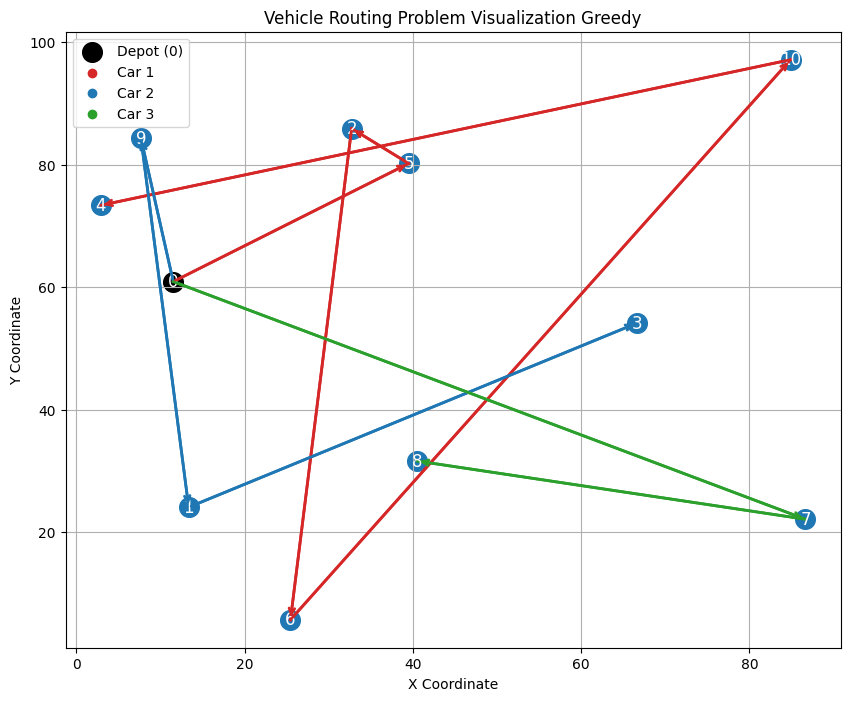

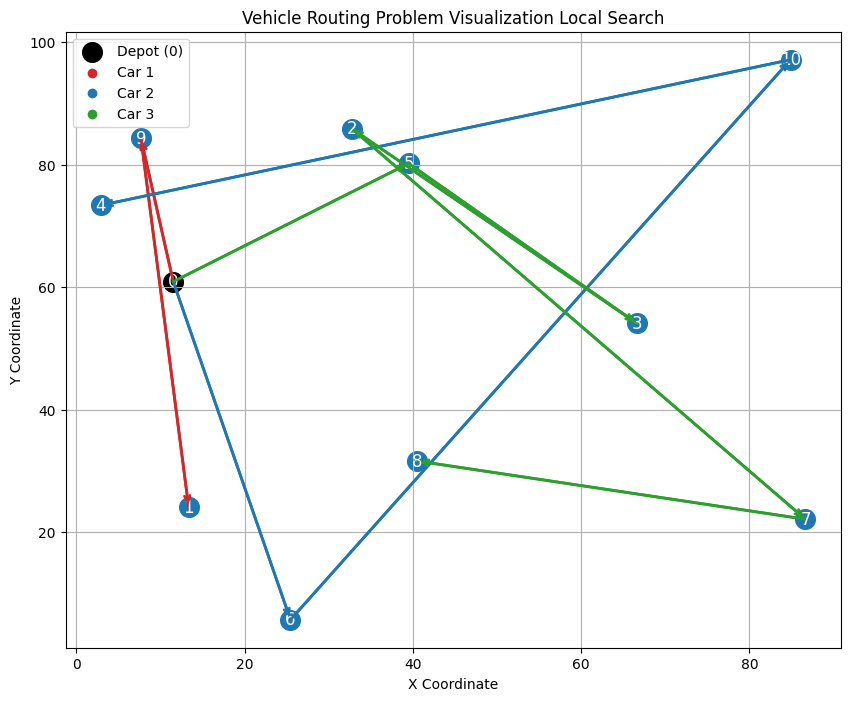

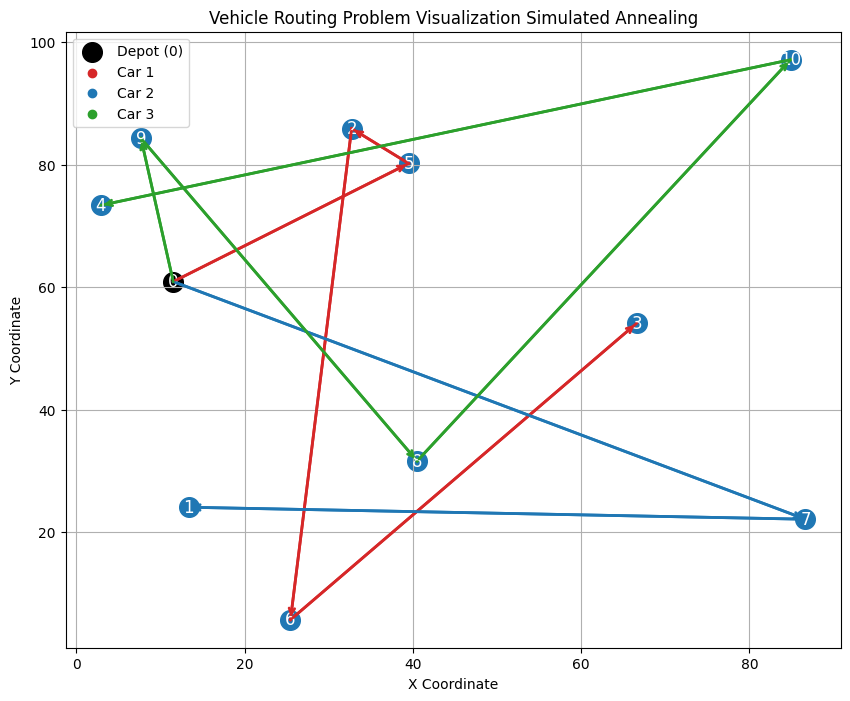

Tabu Search completed. Best solution cost: 98


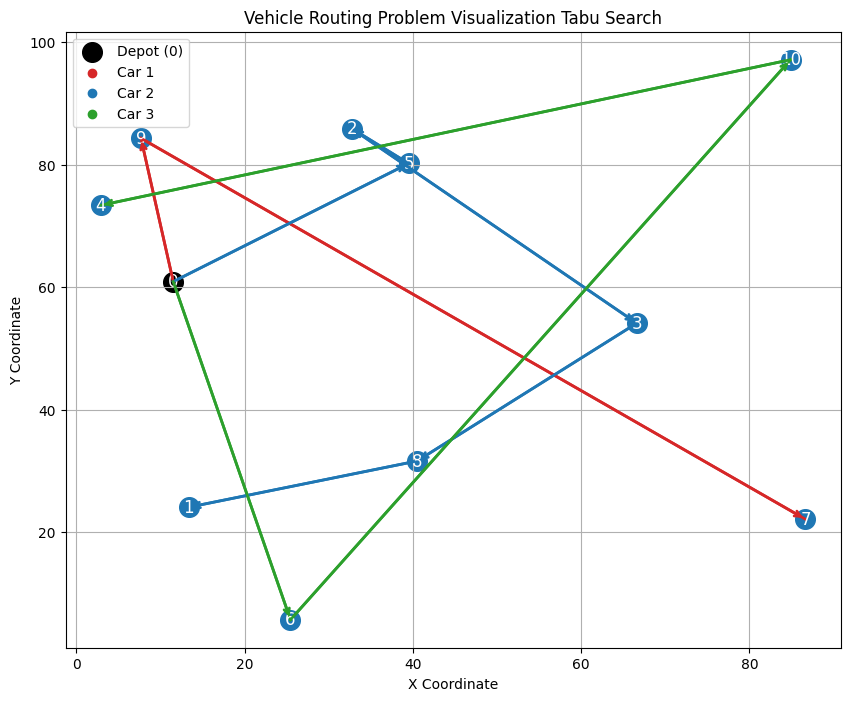

Running large test case...


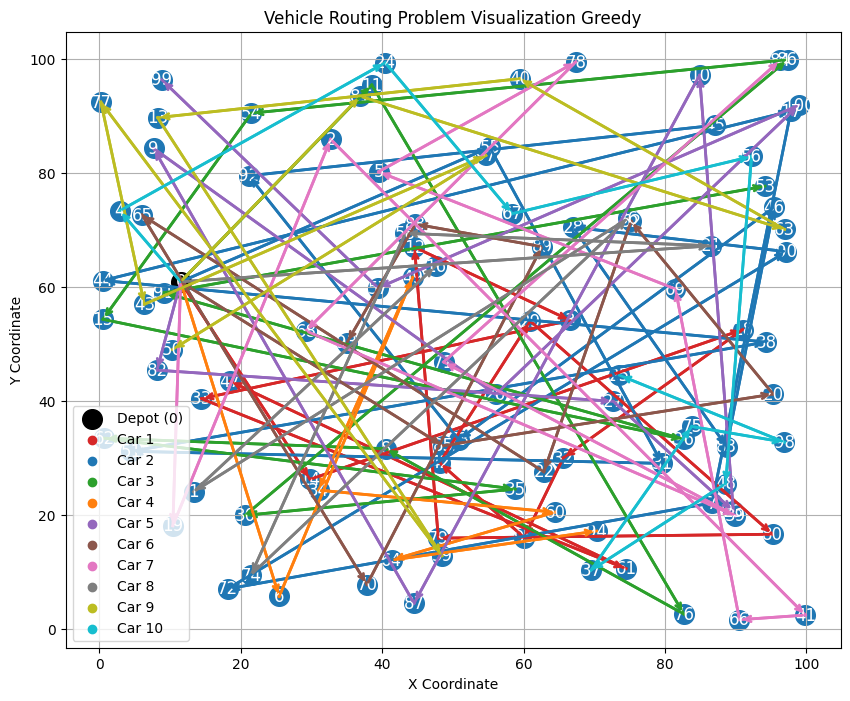

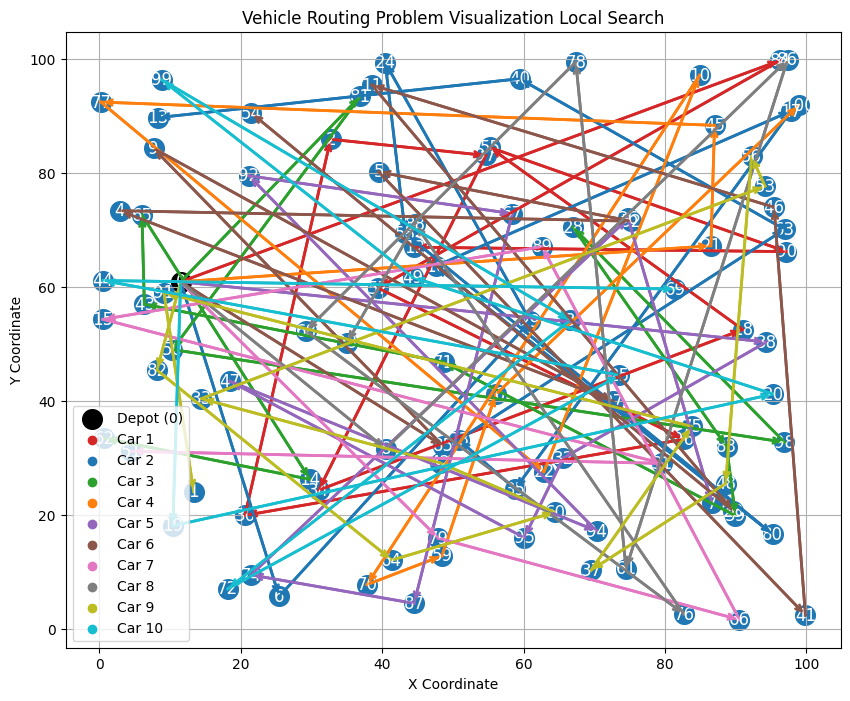

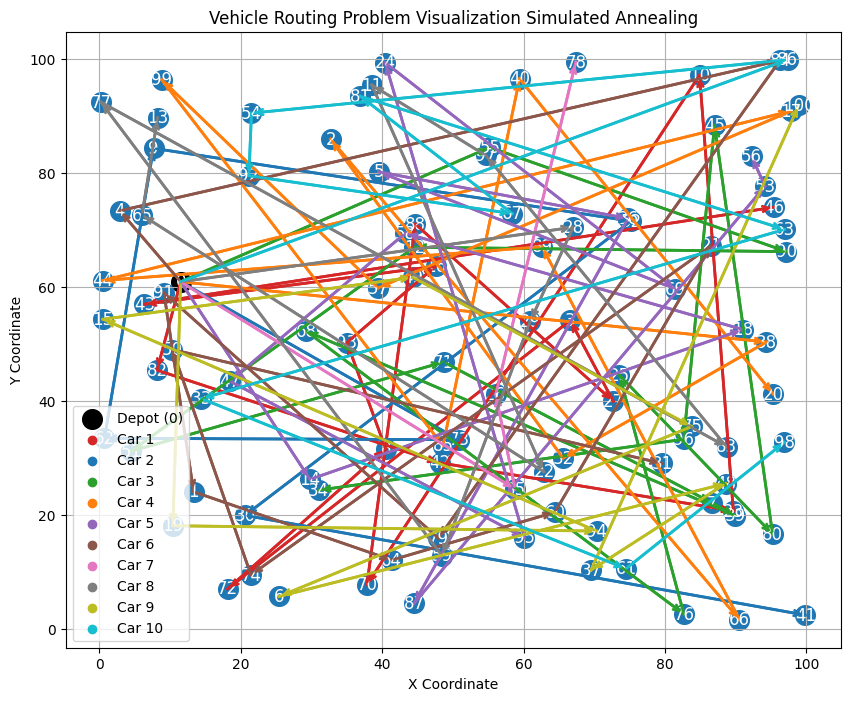

Tabu Search completed. Best solution cost: 82


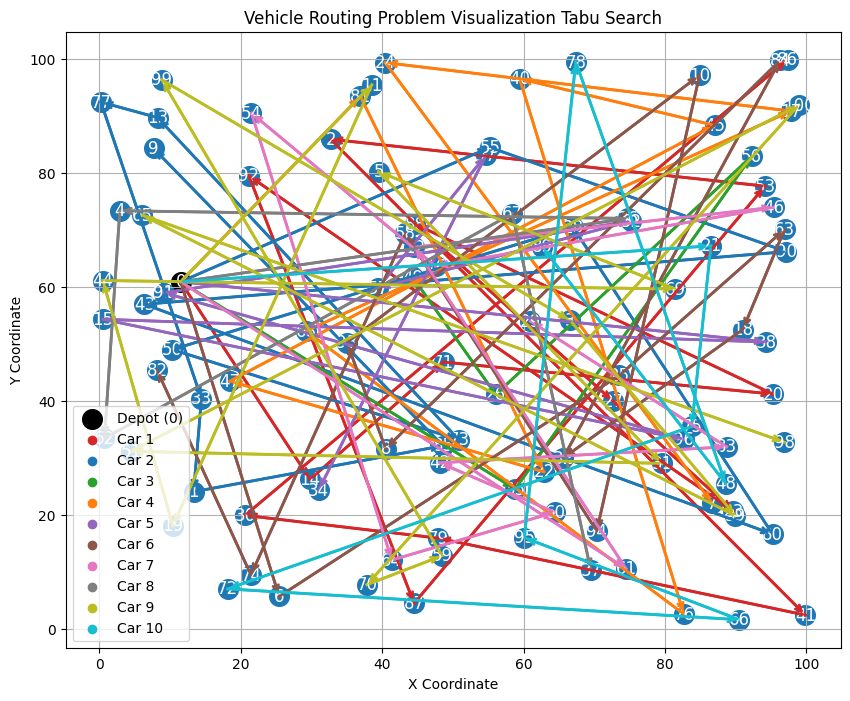

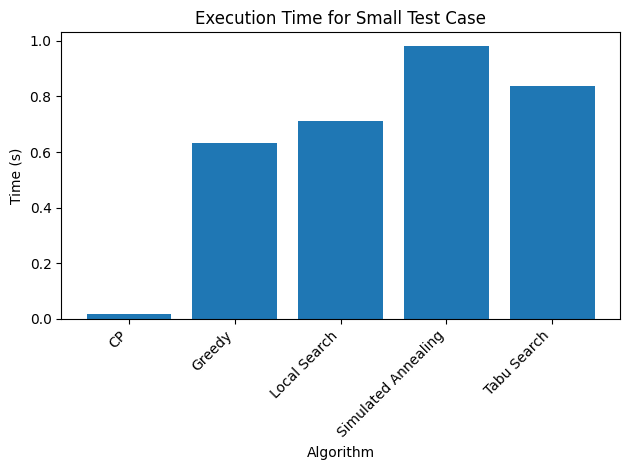

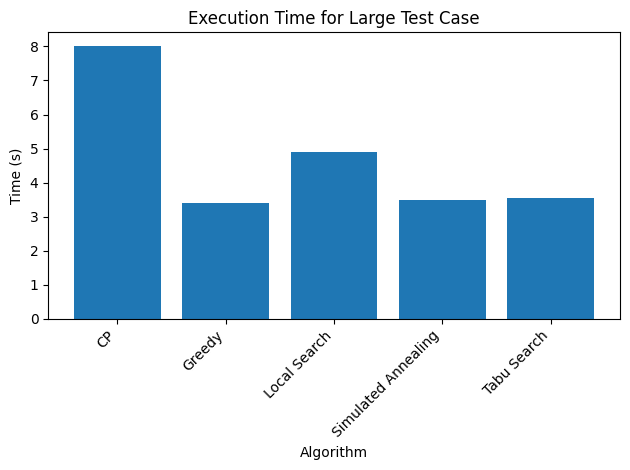

In [71]:
import time
import random
import matplotlib.pyplot as plt

# Generate test cases (small and large)
def generate_test_case(n, k):
    """Generates a random distance matrix for VRP."""
    dis_matrix = [[random.randint(1, 100) if i != j else 0 for j in range(n + 1)] for i in range(n + 1)]
    return n, k, dis_matrix

# Benchmarking
def benchmark_vrp_algorithms():
    test_cases = {
        "small": generate_test_case(10, 3),  # Small test case
        "large": generate_test_case(100, 10)  # Large test case
    }
    results = {algo: {} for algo in ["CP", "Greedy", "Local Search", "Simulated Annealing", "Tabu Search"]}

    for case_name, (n, k, dis_matrix) in test_cases.items():
        print(f"Running {case_name} test case...")
        # Benchmark Constraints Programming
        start_time = time.time()
        solve_cp(n, k, dis_matrix)
        results["CP"][case_name] = time.time() - start_time

        # Benchmark Greedy
        start_time = time.time()
        solve_greedy(n, k, dis_matrix)
        results["Greedy"][case_name] = time.time() - start_time

        # Benchmark Local Search
        start_time = time.time()
        solverls = SolverLS(n, k, dis_matrix)
        solverls.solve()
        solverls.plotCarRoutes()
        results["Local Search"][case_name] = time.time() - start_time

        # Benchmark Simulated Annealing
        start_time = time.time()
        solversa = SolverSA(n, k, dis_matrix)
        solversa.solve()
        solversa.plotCarRoutes()
        results["Simulated Annealing"][case_name] = time.time() - start_time

        # Benchmark Tabu Search
        start_time = time.time()
        solverts = TabuSolver(n, k, dis_matrix)
        solverts.solve()
        solverts.plotCarRoutes()
        results["Tabu Search"][case_name] = time.time() - start_time

    return results

# Visualization
def plot_results(results):
    algorithms = list(results.keys())
    test_cases = list(results[algorithms[0]].keys())

    for test_case in test_cases:
        times = [results[algo][test_case] for algo in algorithms]
        plt.bar(algorithms, times)
        plt.title(f"Execution Time for {test_case.capitalize()} Test Case")
        plt.ylabel("Time (s)")
        plt.xlabel("Algorithm")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Run benchmarks
    results = benchmark_vrp_algorithms()
    # Plot results
    plot_results(results)
